# Wind impact on the Uiramatã-Chuí bike route

In [3]:
%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 2.88 ms


In [4]:
import numpy as np
import xarray as xr

time: 1.31 ms


In [9]:
GPX_PATH = '../data/uiramata_chui.gpx'
NC_PATH = '../data/data.nc'

time: 1.74 ms


In [10]:
raw_ds = xr.load_dataset(NC_PATH)

time: 13 s


In [12]:
g_data = raw_ds.isel(step=0).groupby(raw_ds.time.dt.hour)

m_data = g_data.mean()
s_data = g_data.std()

/home/danlessa/.anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


time: 853 ms


In [53]:
m_data

<xarray.Dataset>
Dimensions:    (hour: 1, latitude: 396, longitude: 221)
Coordinates:
    step       timedelta64[ns] 01:00:00
    surface    int32 0
    number     int32 0
  * longitude  (longitude) float64 -70.0 -69.9 -69.8 -69.7 ... -48.2 -48.1 -48.0
  * latitude   (latitude) float64 5.5 5.4 5.3 5.2 ... -33.7 -33.8 -33.9 -34.0
  * hour       (hour) int64 0
Data variables:
    u10        (hour, latitude, longitude) float32 -0.6391772 ... nan
    v10        (hour, latitude, longitude) float32 0.05270239 0.06904068 ... nan
    tp         (hour, latitude, longitude) float32 0.00013752608 ... nan

time: 81.2 ms


In [147]:
import gpxpy
from geopy.distance import geodesic
import pandas as pd
from tqdm.auto import tqdm
from scipy.optimize import brentq

# Parameters
TOTAL_WEIGHT = 70
CRR = 0.007
CDA = 0.32
INEFFICIENCY = 1.03
RHO = 1.226

# Pacing strategies
STRATEGIES = {'uphill': {'filter': lambda x: x >= 0.5,
                         'power': 125},
              'flat': {'filter': lambda x: (x < 0.5) & (x > -0.5),
                       'power': 100},
              'downhill': {'filter': lambda x: x <= -0.5,
                           'power': 25}}


def power_gravitational(speed, grad, weight=TOTAL_WEIGHT):
    """
    Power for winning gravity
    """
    return 9.8067 * weight * speed * np.sin(np.arctan(grad))


def power_wind(speed, cda=CDA, rho=RHO):
    """
    Power for winning wind
    """
    return 0.5 * rho * cda * (speed ** 3)


def power_rolling(speed, grad, crr=CRR, weight=TOTAL_WEIGHT):
    """
    Power for winning tyres
    """
    return 9.8067 * crr * speed * np.cos(np.arctan(grad)) * weight


def power(speed, grad):
    """
    Overral power
    """
    return (power_gravitational(speed, grad)
            + power_wind(speed)
            + power_rolling(speed, grad)) * INEFFICIENCY


def speed(_power, grad):
    """
    Speed given an power and a grad.
    """
    def optimize_function(speed, grad): return _power - power(speed, grad)
    return brentq(optimize_function, -0.01, 100.0, grad)


def gradient(df):
    N = 15
    return 100 * df.ele.diff().rolling(N).mean() / df.delta.rolling(N).mean()


def calculate_speeds(df):
    # Get the speeds for the route given the pacing strategies
    output = {}
    for strategy, params in tqdm(STRATEGIES.items()):
        grads = df.where(lambda df: params['filter'](df.grad)).grad.dropna()
        speeds = grads.apply(lambda grad: speed(
            params['power'], grad / 100) * 3.6)
        output[strategy] = speeds
        df.loc[grads.index, 'speed'] = speeds
    # Summary
    for strategy, out in output.items():
        print("{}: {:.0f} ({:.0f} to {:.0f}) km/h".format(strategy,
                                                          out.median(), out.quantile(0.05), out.quantile(0.95)))
    speeds = pd.concat(output.values())
    return speeds


def calculate_deltas(df):
    deltas = {}
    for i, (ind, row) in tqdm(enumerate(df.iterrows()),
                              total=len(df),
                              desc='Calculating deltas'):
        lat2 = row.lat
        lon2 = row.lon
        if i > 0:
            delta_x = geodesic((lat1, lon1), (lat1, lon2)).meters
            if lon2 < lon1:
                delta_x *= -1
            delta_y = geodesic((lat1, lon1), (lat2, lon1)).meters
            if lat2 < lat1:
                delta_y *= -1
            delta = geodesic((lat1, lon1), (lat2, lon2)).meters
            deltas[ind] = (delta, delta_x, delta_y)
        (lat1, lon1) = (lat2, lon2)
    return deltas


def load_route(content=False):
    if content is False:
        with open(GPX_PATH, 'r') as fid:
            content = fid.read()
    gpx = gpxpy.parse(content)

    route_points = gpx.tracks[0].segments[0].points
    df = (pd.DataFrame([(p.longitude, p.latitude, p.elevation) for p in route_points],
                       columns=['lon', 'lat', 'ele'])
          .drop_duplicates(subset=['lat', 'lon'])
          )
    deltas = calculate_deltas(df)
    delta = {k: v[0] for k, v in deltas.items()}
    delta_x = {k: v[1] for k, v in deltas.items()}
    delta_y = {k: v[2] for k, v in deltas.items()}
    df = df.join(pd.Series(delta, name='delta'))
    df = df.join(pd.Series(delta_x, name='delta_x'))
    df = df.join(pd.Series(delta_y, name='delta_y'))
    df = df.assign(u_x=lambda df: df.delta_x / df.delta)
    df = df.assign(u_y=lambda df: df.delta_y / df.delta)
    df = df.assign(grad=gradient)
    df['grad'] = df.grad
    speeds = df.pipe(calculate_speeds)

    df = df.assign(total_distance=df.delta.cumsum() / 1000)
    df = df.assign(duration=df.delta / (1000 * df.speed))
    df = df.assign(total_duration=df.duration.cumsum())
    df = df.assign(days=df.total_duration // 8)
    df = df.assign(hours=df.total_duration // 1)
    return df

time: 8.47 ms


In [148]:
route_data = load_route().dropna()

100%|██████████| 3/3 [00:14<00:00,  4.82s/it]

uphill: 20 (9 to 24) km/h
flat: 25 (23 to 27) km/h
downhill: 27 (17 to 53) km/h
time: 1min 43s


In [ ]:
def get_wind_metrics(ds, lat, lon, hour):
    summary = ds.sel(latitude=lat, longitude=lon,
                     hour=hour, method='nearest')  # %%
    return (summary.u10, summary.v10)

wind_speed_mean = {}
wind_speed_std = {}
(w_u, w_v) = get_wind_metrics(m_data, route_data.lat, route_data.lon, 12)
m_w_s = w_u ** 2 + w_v ** 2

(w_u, w_v) = get_wind_metrics(s_data,route_data.lat, route_data.lon, 12)
s_w_s = w_u ** 2 + w_v ** 2

In [144]:
route_data = route_data.join(pd.Series(np.diag(m_w_s.values), name='wind_speed_mean'))
route_data = route_data.join(pd.Series(np.diag(s_w_s.values), name='wind_speed_std'))

time: 5.58 ms


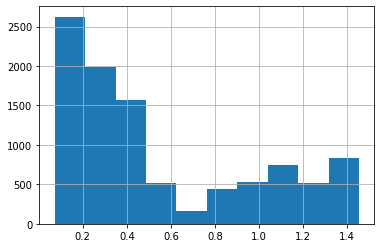

time: 156 ms


In [145]:
route_data.wind_speed_mean.hist()

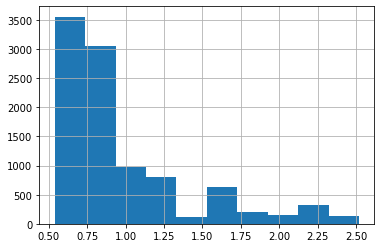

time: 173 ms


In [146]:
route_data.wind_speed_std.hist()